In [1]:
import pandas as pd
import numpy as np
import os
from pcntoolkit.dataio.fileio import load as ptkload
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
import matplotlib as mpl
from pathlib  import Path
from pcntoolkit.dataio.fileio import save_nifti, load_nifti
from pcntoolkit.dataio.fileio import save as ptksave

import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("husl", 9)


# globals
root_dir = '/project_cephfs/3022017.06/ENIGMA_ANX/'
proc_dir = os.path.join(root_dir,'Z_stat/')
data_dir = os.path.join(proc_dir,'data/')
w_dir = os.path.join(proc_dir,'vox/')
mask_nii = ('/opt/fmriprep/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-02_desc-brain_mask.nii.gz')
ex_nii = os.path.join(data_dir, 'ENIGMA_FC_tr_1.nii.gz')


/home/preclineu/hansav/.conda/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#SVM classification Contingency Aware vs Unaware

#%%LOAD IN DATA AND MASK BY AVAILABLE PARTICIPANTS
# Load in the Z_est files
Z_est_control_test = ptkload(os.path.join(w_dir,'Z_estimate.pkl'), mask=mask_nii)
Z_est_clinical = ptkload(os.path.join(w_dir,'Z_predcl.pkl'), mask=mask_nii)
Full_sample_deviations = np.append(Z_est_control_test,Z_est_clinical, axis = 0)

#Load in the contingency awareness data
Status = pd.read_csv('/project_cephfs/3022017.06/ENIGMA_ANX/Z_stat/data/all_test_validation.csv', usecols = ['Healthy_or_patient', 'Principal_diagnosis_current'])
Status['Principal_diagnosis_current'] = Status['Principal_diagnosis_current'].replace({np.nan: 'NA', 'nan': 'NA'})

#REPLACE ALL NOT AVAILABLE with NA
Status.replace(to_replace='not assessed/not available', value='NA', regex=True, inplace=True)
Status.replace(to_replace='not available', value='NA', regex=True, inplace=True)
Status.replace(to_replace='not applicable', value='NA', regex=True, inplace=True)

mask_exclude_diagnosis = ~Status['Principal_diagnosis_current'].isin(['others', 'schizophrenia']) #and remove others and schizophrenia

Status_yes_no = Status['Healthy_or_patient'][mask_exclude_diagnosis].to_numpy()
Status_deviations = Full_sample_deviations[mask_exclude_diagnosis]

print('Status data is available for '+str(len(Status_yes_no)) +' participants')

Status data is available for 1128 participants


In [3]:
print(Status_yes_no)
# Recode the data into integers for classification
mapping = {'healthy': 1, 'patient': 2}
# Recode the data using list comprehension
Status_yes_no = [mapping[item] for item in Status_yes_no]
Status_yes_no = np.array(Status_yes_no)

print(Status_yes_no)

['healthy' 'healthy' 'healthy' ... 'healthy' 'healthy' 'healthy']
[1 1 1 ... 1 1 1]


In [4]:
#Define parameters
X1 = Status_deviations #Deviations
y = Status_yes_no.ravel()
n_samples, n_features = X1.shape
random_state = np.random.RandomState(0)

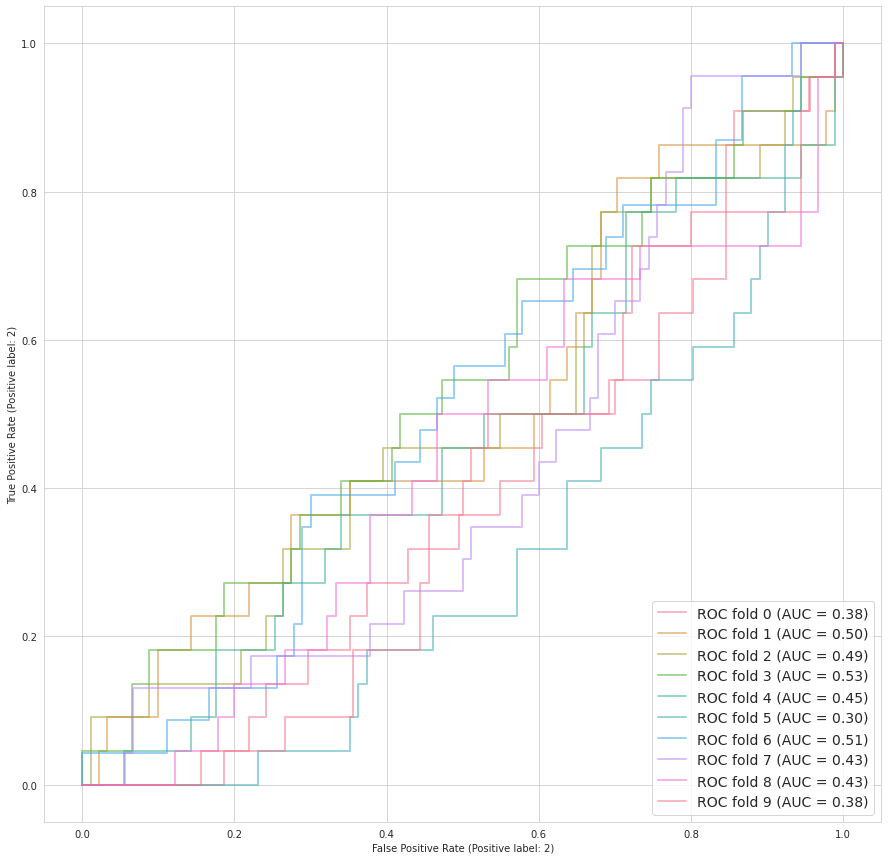

In [5]:
#RUN CLASSIFICATION with 10-cross fold stratificiation
cv = StratifiedKFold(n_splits=10)

classifier_z = svm.SVC(kernel="linear", probability=True, random_state=random_state, class_weight='balanced')

tprs_z = []
aucs_z = []
aucs_z_perms = []
mean_auc_z_perms = []
coefs = []
mean_fpr_z = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(15,15))
fpath = Path(mpl.get_data_path(), "/project_cephfs/3022017.06/ENIGMA_ANX/arial.ttf")
parameters = {'axes.labelsize': 20,
          'axes.titlesize': 25, 'xtick.labelsize':16,'ytick.labelsize':16,'legend.fontsize':14,'legend.title_fontsize':16}
plt.rcParams.update(parameters)
    
for i, (train, test) in enumerate(cv.split(X1, y)):
    classifier_z.fit(X1[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier_z,
        X1[test],
        y[test],
        name="ROC fold {}".format(i),
        alpha=0.5,
        lw=2,
        ax=ax,
    )
    interp_tpr_z = np.interp(mean_fpr_z, viz.fpr, viz.tpr)
    interp_tpr_z[0] = 0.0
    tprs_z.append(interp_tpr_z)
    aucs_z.append(viz.roc_auc)
    coefs.append(classifier_z.coef_)

mean_tpr_z = np.mean(tprs_z, axis=0)
mean_tpr_z[-1] = 1.0
mean_auc_z = auc(mean_fpr_z, mean_tpr_z)
std_auc_z = np.std(aucs_z)
aucs_z_perms.append(aucs_z)
mean_auc_z_perms.append(mean_auc_z)


np.save((os.path.join(w_dir +'Validation/Patient_status_mean_auc.npy')), mean_auc_z_perms)
np.save((os.path.join(w_dir +'Validation/Patient_status_std_auc.npy')), std_auc_z)
np.save((os.path.join(w_dir +'Validation/Patient_status_coefs.npy')), coefs)


In [6]:
#save voxels level coefficients
coefs_mean =  np.mean(coefs, axis=0) #save as nifti
out_filename = (w_dir +'Validation/Patient_status_meanCoefs.nii.gz')
ptksave(coefs_mean, out_filename, example=ex_nii, mask=mask_nii)
